In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random as rand
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [72]:
df = pd.read_csv('data/train.csv')
df.head()

,ID,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
0,0,Alabama,04-12-2020,3563,93,NaN,3470.0,75.988020,21583.0,437.0,2.610160,460.300152,12.264945
1,1,Alaska,04-12-2020,272,8,66.0,264.0,45.504049,8038.0,31.0,2.941176,1344.711576,11.397059
2,2,Arizona,04-12-2020,3542,115,NaN,3427.0,48.662422,42109.0,NaN,3.246753,578.522286,NaN
3,3,Arkansas,04-12-2020,1280,27,367.0,1253.0,49.439423,19722.0,130.0,2.109375,761.753354,10.156250
4,4,California,04-12-2020,22795,640,NaN,22155.0,58.137726,190328.0,5234.0,2.812020,485.423869,22.961176


In [73]:
df.dtypes

ID                        int64
Province_State           object
Date                     object
Confirmed                 int64
Deaths                    int64
Recovered               float64
Active                  float64
Incident_Rate           float64
People_Tested           float64
People_Hospitalized     float64
Mortality_Rate          float64
Testing_Rate            float64
Hospitalization_Rate    float64
dtype: object

In [74]:
df.describe()
# 7100 samples

,ID,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
count,7100.000000,7100.000000,7100.000000,5771.000000,7100.000000,7100.000000,7.100000e+03,5047.000000,7100.000000,7100.000000,5047.000000
mean,3549.500000,56374.339577,2323.883099,20422.274649,37635.120986,747.273790,6.427069e+05,6250.044185,3.653231,9666.099116,12.197144
std,2049.737788,95058.665054,4742.274729,39262.213465,79067.101832,637.397470,1.127555e+06,13880.694435,2.074042,7779.560336,5.255183
min,0.000000,270.000000,0.000000,0.000000,-989.000000,32.771004,5.459000e+03,10.000000,0.000000,460.300152,2.302896
25%,1774.750000,6097.500000,153.000000,1614.500000,2849.000000,224.815702,1.000775e+05,595.000000,1.928925,3379.288445,8.387037
50%,3549.500000,22892.000000,681.000000,5881.000000,10409.000000,540.836745,2.643235e+05,2068.000000,3.362027,7842.820591,11.351161
75%,5324.250000,62959.250000,2334.000000,26103.000000,32106.500000,1126.282666,7.048395e+05,6134.500000,4.797564,14127.521137,15.396088
max,7099.000000,712475.000000,32957.000000,507499.000000,699453.000000,3187.773001,1.137330e+07,89995.000000,9.741481,49502.860687,38.501190


In [75]:
cat = list(df.columns)
# numerical data columns
cat_num = cat[3:]
cat_num

['Confirmed',
 'Deaths',
 'Recovered',
 'Active',
 'Incident_Rate',
 'People_Tested',
 'People_Hospitalized',
 'Mortality_Rate',
 'Testing_Rate',
 'Hospitalization_Rate']

In [76]:
df.isnull().sum()

ID                         0
Province_State             0
Date                       0
Confirmed                  0
Deaths                     0
Recovered               1329
Active                     0
Incident_Rate              0
People_Tested              0
People_Hospitalized     2053
Mortality_Rate             0
Testing_Rate               0
Hospitalization_Rate    2053
dtype: int64

In [77]:
# Change from string type to datetime
df['Date'] = pd.to_datetime(df['Date'])
# group data by category for cleaning
grouped = df.groupby('Province_State')
df_clean = pd.DataFrame()
scaler = preprocessing.StandardScaler()


for name, group in grouped:
    # drop column if more than 70% of data is NaN
    group.dropna(axis=1, thresh=.7 * len(group.index))
    for cat in cat_num:
        # impute using column median
        group[cat].fillna(group[cat].median(), inplace=True)
        # Standard Scale numeric columns (State-wise)
        mean = group[cat].mean()
        var = group[cat].var()
        group[cat] = group[cat].apply(lambda x : (x - mean)/var)
    df_clean = pd.concat([df_clean, group], ignore_index=True)

# # Standard Scale all numeric columns (GLOBALLY)
df_clean[df_clean.select_dtypes('number').columns[1:]] = scaler.fit_transform(df_clean[df_clean.select_dtypes('number').columns[1:]])
# cleaned df
df_clean



,ID,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
0,0,Alabama,2020-04-12,-0.044806,-0.068071,0.004327,-0.026859,-0.265734,-0.410296,-0.003655,-0.114892,-1.296417,0.142857
1,50,Alabama,2020-04-13,-0.044625,-0.067609,0.004327,-0.026665,-0.264615,-0.402261,-0.003638,-0.084346,-1.269854,0.142857
2,100,Alabama,2020-04-14,-0.044395,-0.066455,0.004327,-0.026424,-0.263182,-0.398100,-0.003608,0.088281,-1.256099,0.142857
3,150,Alabama,2020-04-15,-0.044266,-0.066148,0.004327,-0.026285,-0.262383,-0.397085,-0.003581,0.097055,-1.252743,0.142857
4,200,Alabama,2020-04-16,-0.043982,-0.064994,0.004327,-0.025984,-0.260616,-0.394638,-0.003557,0.219737,-1.244654,0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7095,6899,Wyoming,2020-08-27,2.975485,5.454874,2.484224,6.360776,2.133801,9.279846,0.735571,-0.943870,3.561100,0.142857
7096,6949,Wyoming,2020-08-28,3.074219,5.454874,2.519914,7.475375,2.205223,9.441479,-0.095153,-1.022567,3.623652,0.142857
7097,6999,Wyoming,2020-08-29,3.062935,5.454874,2.561095,6.512767,2.197060,9.446300,-0.095153,-1.013720,3.625518,0.142857
7098,7049,Wyoming,2020-08-30,3.110891,5.454874,2.588550,6.867412,2.231751,9.454566,-0.095153,-1.051064,3.628716,0.142857


In [78]:
def MAPE(predicted, actual):
    assert len(predicted) == len(actual)
    res = 0
    for i in range(len(predicted)):
        diff = np.abs(predicted[i] - actual[i]) / np.abs(actual[i])
        res += diff
    return (res/len(predicted)) * 100

In [79]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [80]:
n_steps = 6
n_features = 1

In [81]:
cali_norm = df_clean[df_clean['Province_State'] == 'California']['Confirmed']
print(cali_norm)

568   -0.008282
569   -0.008244
570   -0.008196
571   -0.008152
572   -0.008119
         ...   
705    0.014065
706    0.014251
707    0.014407
708    0.014537
709    0.014755
Name: Confirmed, Length: 142, dtype: float64


In [82]:
cali_norm_train = pd.Series.tolist(cali_norm[:112])
cali_norm_test = pd.Series.tolist(cali_norm[112:])

In [83]:
X, y = split_sequence(cali_norm_train, n_steps)
print(len(X), len(y))

106 106


In [84]:
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [85]:
from keras.layers import Bidirectional

In [86]:
model2 = Sequential()
model2.add(Bidirectional(LSTM(125, activation='relu'), input_shape=(n_steps, n_features)))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')

In [87]:
model2.fit(X, y, epochs = 400, verbose = 0)

In [88]:
y_hat = []
cur_input = cali_norm_train[-1 * n_steps:]
for i in range(30):
    x_input = np.array(cur_input)
    x_input = x_input.reshape((1, n_steps, n_features))
    y = model2.predict(x_input, verbose = 0)
    y_hat.append(y[0][0])
    cur_input.append(y[0][0])
    cur_input.pop(0)
print(y_hat)

[0.008055699, 0.008363012, 0.0086566815, 0.008920105, 0.009180278, 0.009436511, 0.0097006885, 0.009980954, 0.010256197, 0.010524037, 0.010791014, 0.011055659, 0.0113192955, 0.011579935, 0.011835666, 0.012086363, 0.012332592, 0.012573057, 0.012807096, 0.013035047, 0.013256833, 0.013470733, 0.013676708, 0.013874535, 0.014063985, 0.014245522, 0.014419111, 0.01458512, 0.014742943, 0.014893201]


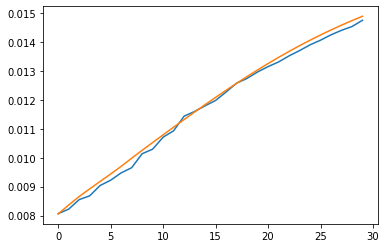

In [89]:
plt.plot(cali_norm_test)
plt.plot(y_hat)

Try reversing the normalization

In [90]:
sigma_2 = df[df['Province_State'] == 'California']['Confirmed'].var()
mu = df[df['Province_State'] == 'California']['Confirmed'].mean()

In [91]:
cali_test = []
pred = []
for i in range(30):
    pred_y = y_hat[i] * sigma_2 + mu
    cali_test_i = cali_norm_test[i] * sigma_2 + mu
    cali_test.append(cali_test_i)
    pred.append(pred_y)

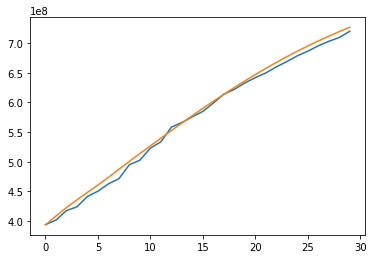

In [92]:
plt.plot(cali_test)
plt.plot(pred)

In [93]:
print(MAPE(pred, cali_test))

1.2106718661583649
